In [1]:
import numpy as np
import rioxarray as rio
import xarray as xr
import pygmt
import pandas as pd
import geopandas as gpd
from shapely import geometry

In [2]:
def get_extent(xds):
    extent = [float(xds.coords['x'].min().values), float(xds.coords['x'].max().values), float(xds.coords['y'].min().values), float(xds.coords['y'].max().values)]
    return extent

def get_bounds(b):
    e = b.values[0]
    ex = [(e[0], e[1]), (e[2], e[1]), (e[2], e[3]), (e[0], e[3])]
    return ex

def get_linestrings(gdf):
    linestrings = []
    for idx in gdf.T:
        geom = gdf.loc[idx].geometry
        if isinstance(geom, geometry.Polygon):
            boundary = geom.boundary
            if isinstance(boundary, geometry.MultiLineString):
                for ls in boundary:
                    linestrings.append(ls)        
            else:
                linestrings.append(boundary)    
        elif isinstance(geom, geometry.LineString):
            linestrings.append(geom)
        elif isinstance(geom, geometry.MultiLineString):
            for ls in geom:
                linestrings.append(ls)                    
    return linestrings

def plot_ls(fig, linestrings, pen):
    for line in linestrings:
        x, y = line.coords.xy
        fig.plot(x=x, y=y, pen=pen)
    return fig

In [3]:
# load KNMI radar data
filename_h5 = 'RAD_NL25_PCP_NA_201910281900.h5'

# define x and y values
# !! based on center coordinates of cells
xs = np.mgrid[500:700500:1000]
ys = np.mgrid[-3650500:-3650500-765000:-1000]

# proj defintions
proj4_rad = '+proj=stere +x_0=0 +y_0=0 +lat_0=90 +lon_0=0 +lat_ts=60 +a=6378137 +b=6356752 +units=m'
proj4_rd = '+proj=sterea +lat_0=52.15616055555555 +lon_0=5.38763888888889 +k=0.9999079 +x_0=155000 +y_0=463000 +ellps=bessel +units=m +no_defs +<>'
proj4_wgs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

# open raw radar data
xds = xr.open_dataset(filename_h5, group='/image1')
xds = xds.where(xds.image_data != 255) 
xds = xds.astype(float)
xds = xds.rename_dims({'phony_dim_0':'y', 'phony_dim_1':'x'})
xds = xds.assign_coords({'y':ys,'x' :xs})

# assign current projection and reproject
xds = xds.rio.write_crs(rio.crs.CRS.from_proj4(proj4_rad))
xds_rd = xds.rio.reproject(proj4_rd)
xds_rd = xds_rd.where(xds_rd.image_data != -9999.) 
xds_rd = xds_rd.image_data
xds_wgs = xds.rio.reproject(proj4_wgs)
xds_wgs = xds_wgs.image_data
ex_rd = get_extent(xds_rd)
ex_wgs = get_extent(xds_wgs)

In [4]:
# clip geometries based on image extent
# prepare mask
bounds_grid = get_bounds(pd.DataFrame(np.array([ex_rd[0], ex_rd[2], ex_rd[1], ex_rd[3]])).T)
mask = geometry.Polygon(bounds_grid)

# load data
gdf = gpd.read_file(r'ne_10m_coastline/ne_10m_coastline.shp')
gdf = gdf.to_crs(epsg=28992)
gdf_nl = gpd.clip(gdf, mask)

linestrings = get_linestrings(gdf_nl)

In [5]:
grid = xds_rd.where(xds_rd > 1) 

In [6]:
REGION = f'{ex_rd[0]}/{ex_rd[1]}/{ex_rd[2]}/{ex_rd[3]}+ue'
PROJ = 'x1:4000000'
PROJ_LL = 's5.387/90/1:4000000'

In [7]:
with pygmt.config(COLOR_NAN = '255/255/255'):
    pygmt.makecpt(series = [0,120,1], cmap = 'no_green', output = 'precip.cpt')

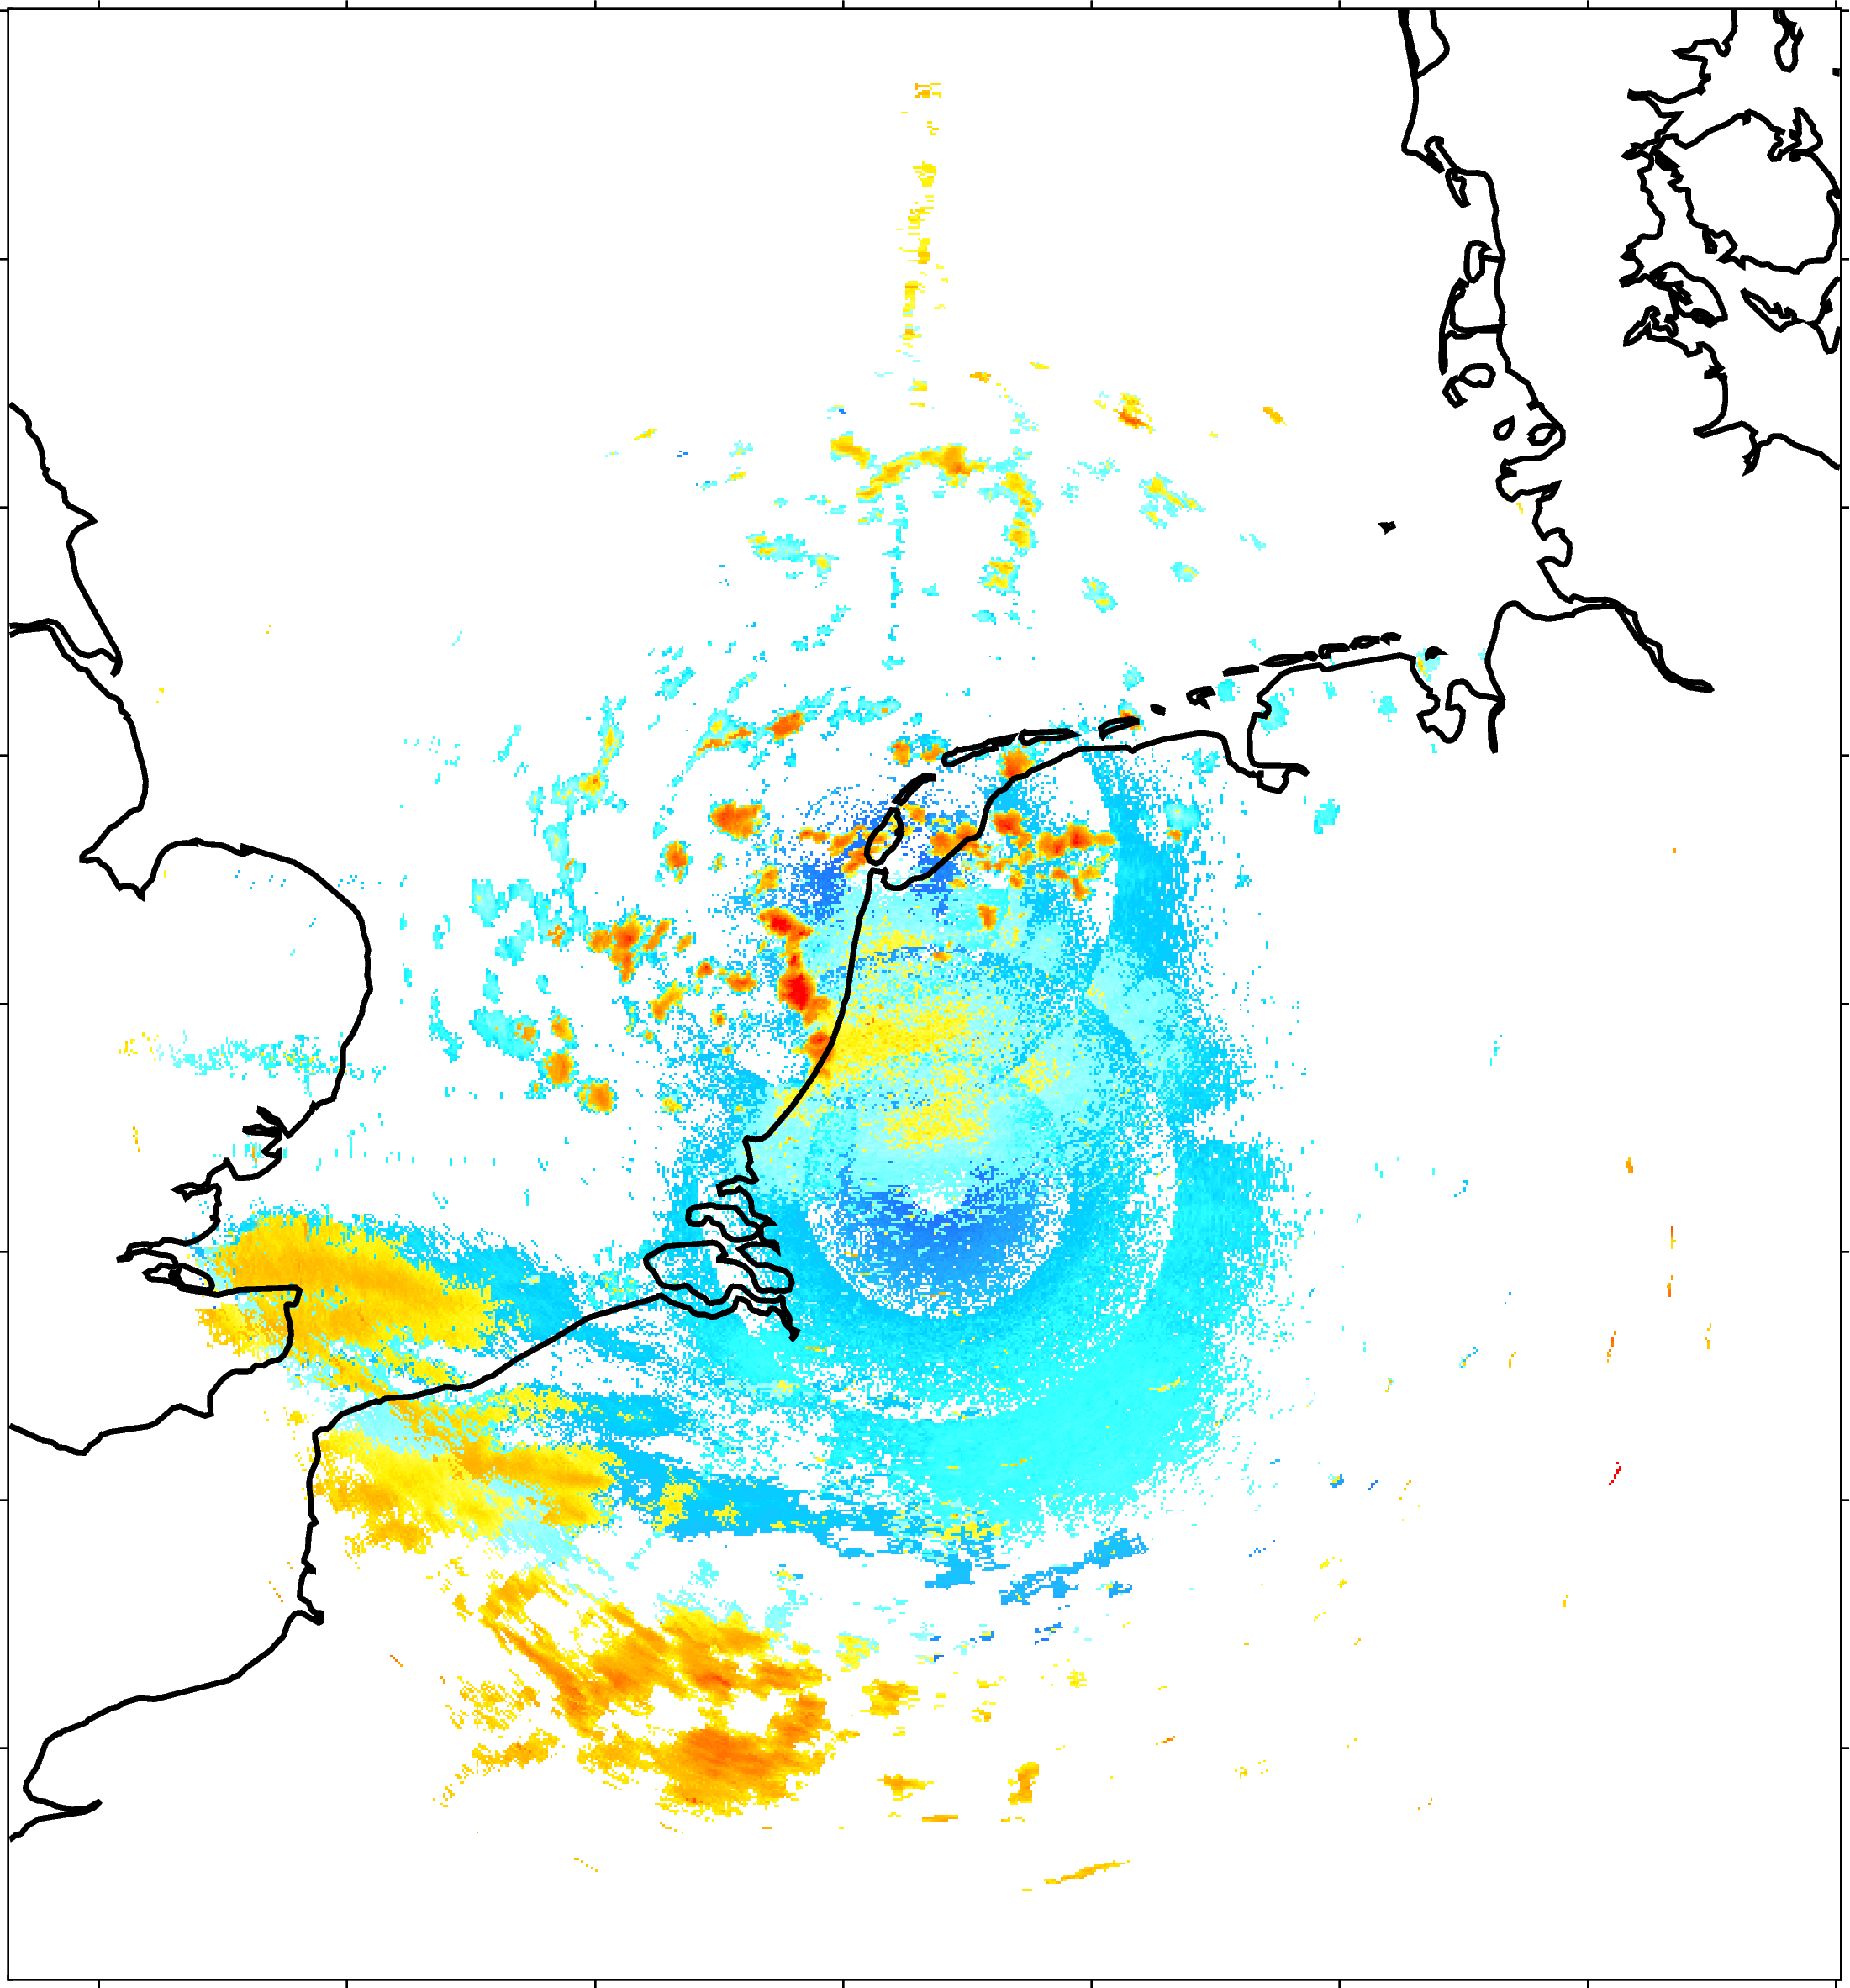

In [8]:
fig = pygmt.Figure()
fig.basemap(region=REGION, projection=PROJ, frame=["nwse", "xf100000", "yf100000"])
fig.grdimage(grid, cmap='precip.cpt', Q=False)
plot_ls(fig, linestrings, pen='1.5p,black')
fig.show()    

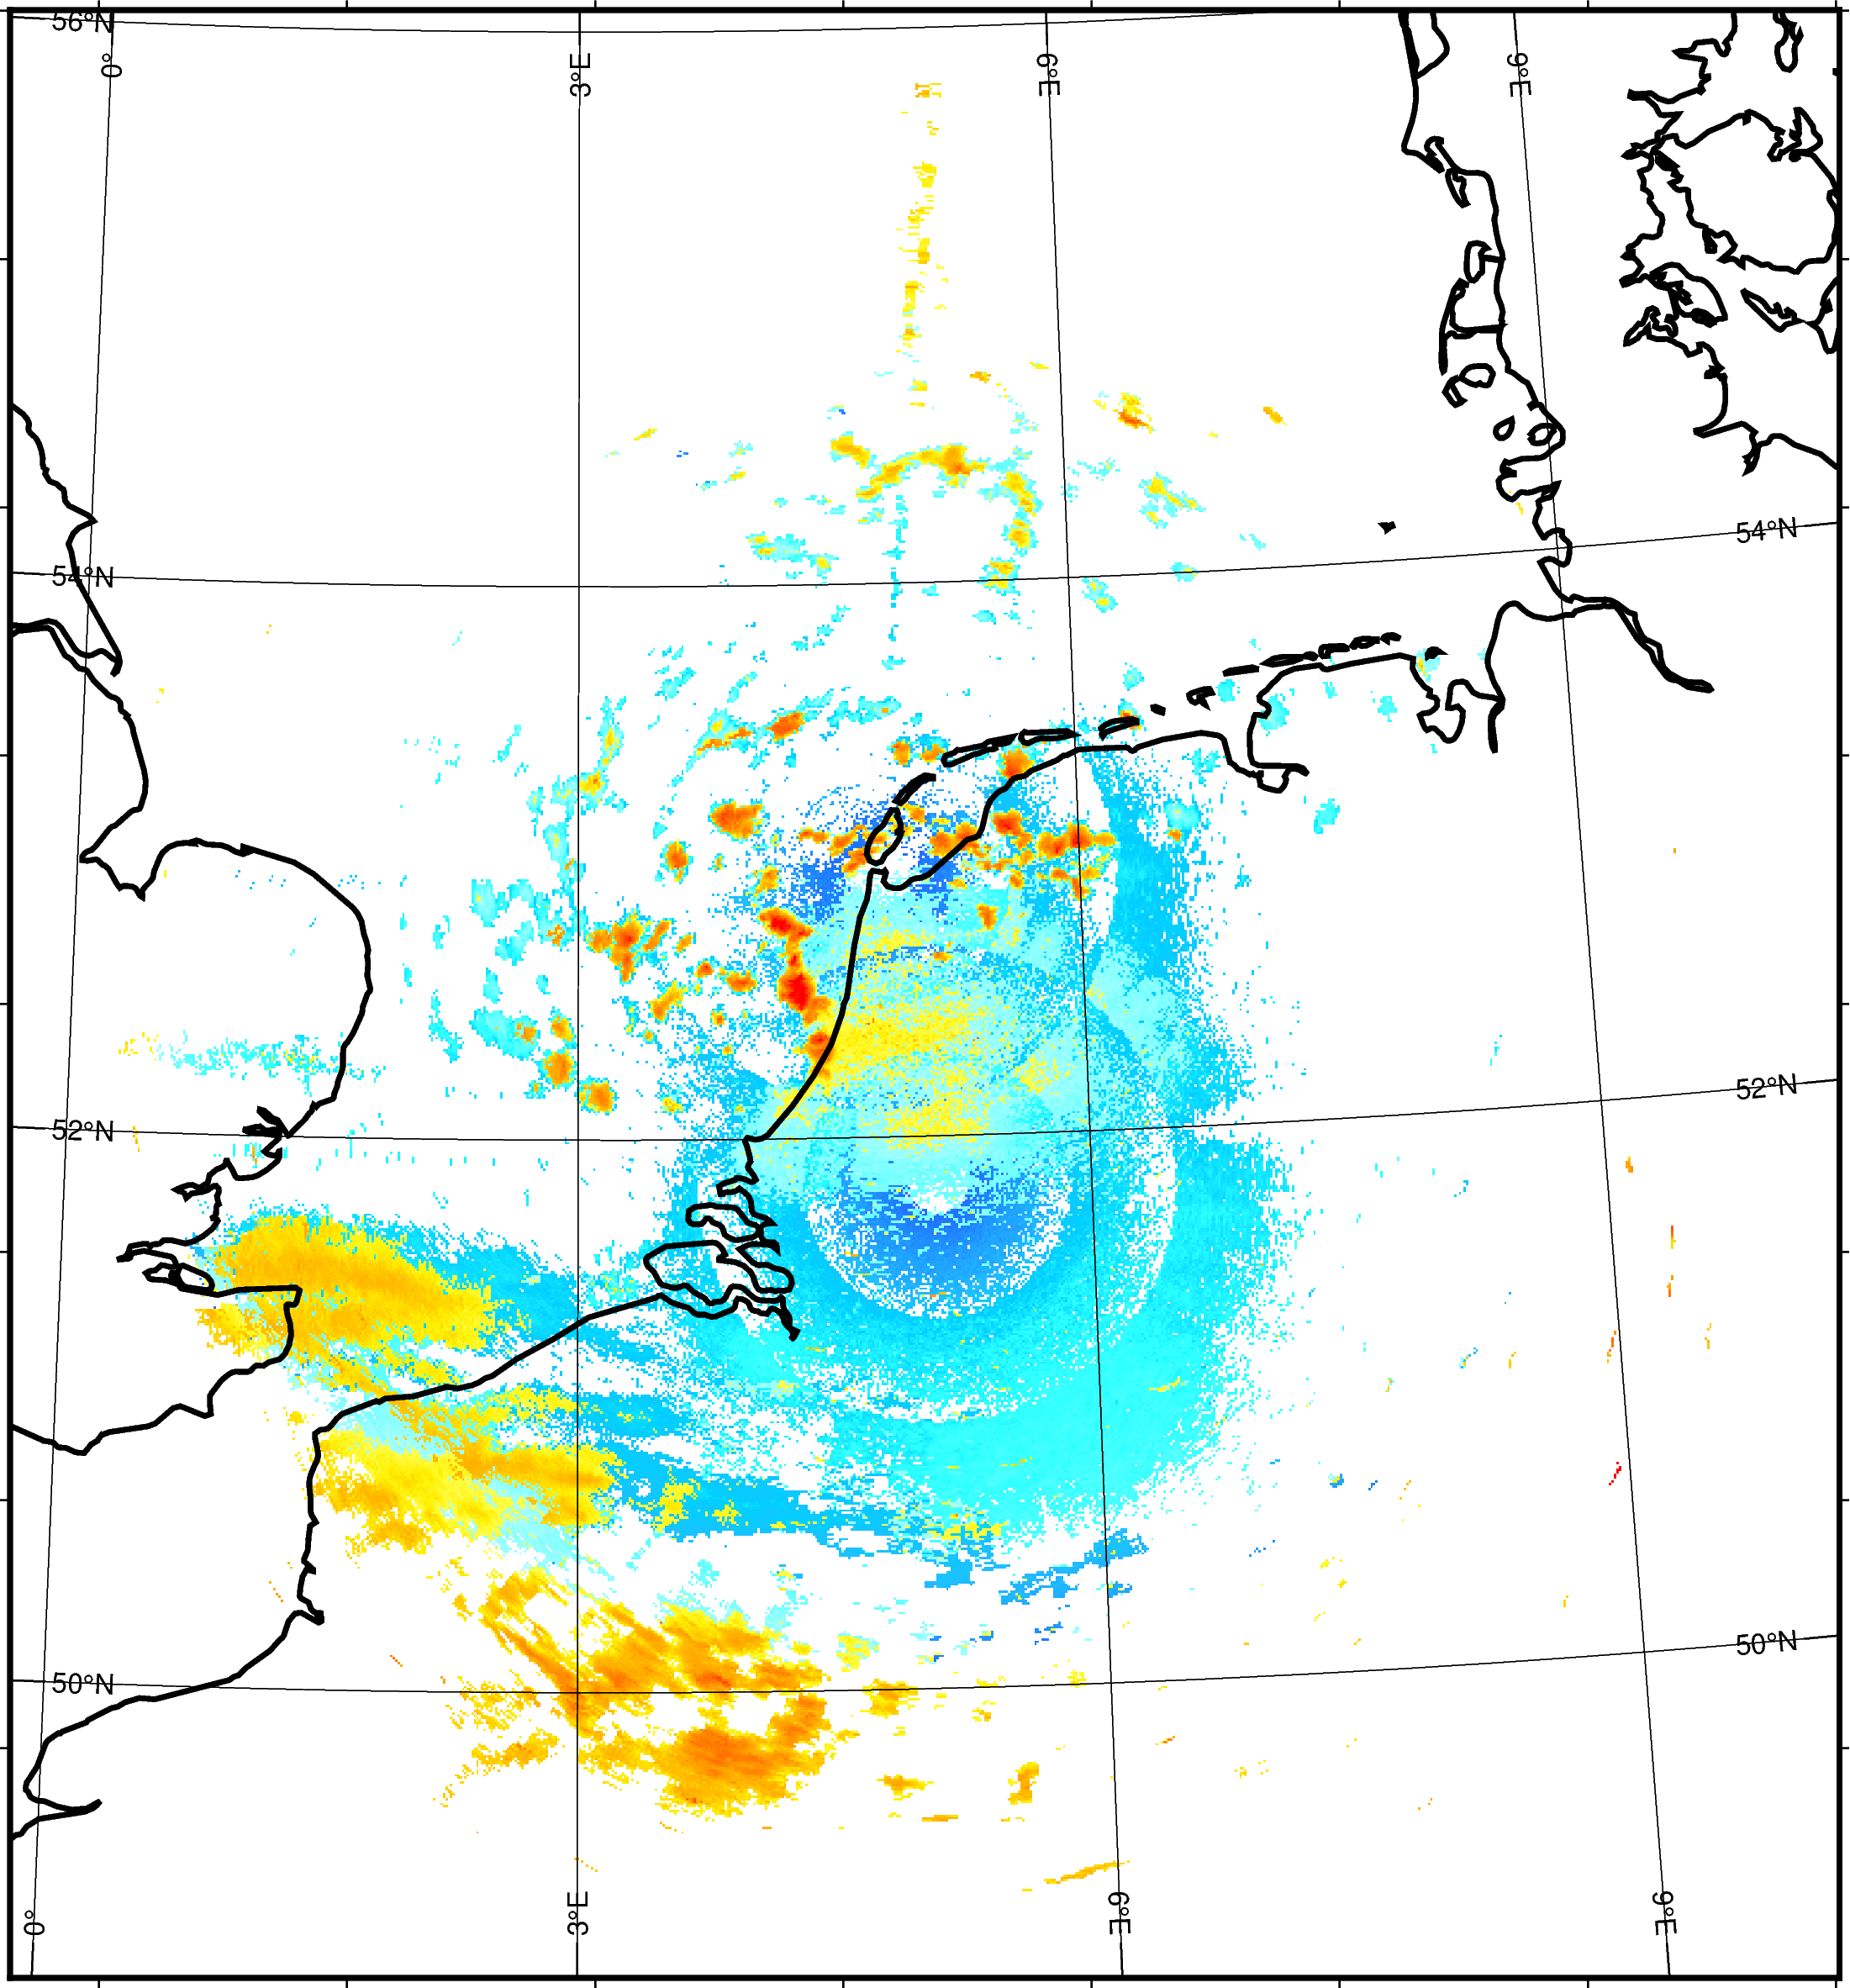

In [9]:
with pygmt.config(MAP_ANNOT_OFFSET_PRIMARY = '-2p', MAP_FRAME_TYPE = 'inside',
                  MAP_ANNOT_OBLIQUE = 0, FONT_ANNOT_PRIMARY = '8p,black',
                  MAP_GRID_PEN_PRIMARY = 'black', MAP_TICK_LENGTH_PRIMARY = '-10p',
                  MAP_TICK_PEN_PRIMARY = 'thinner,black', FORMAT_GEO_MAP = 'dddF',
                  MAP_POLAR_CAP = '90/90'):
    fig.basemap(region=REGION, projection=f's3.1/48/1:4000000', frame=["NSWE", "xa3g3", "ya2g2"])

fig.show()

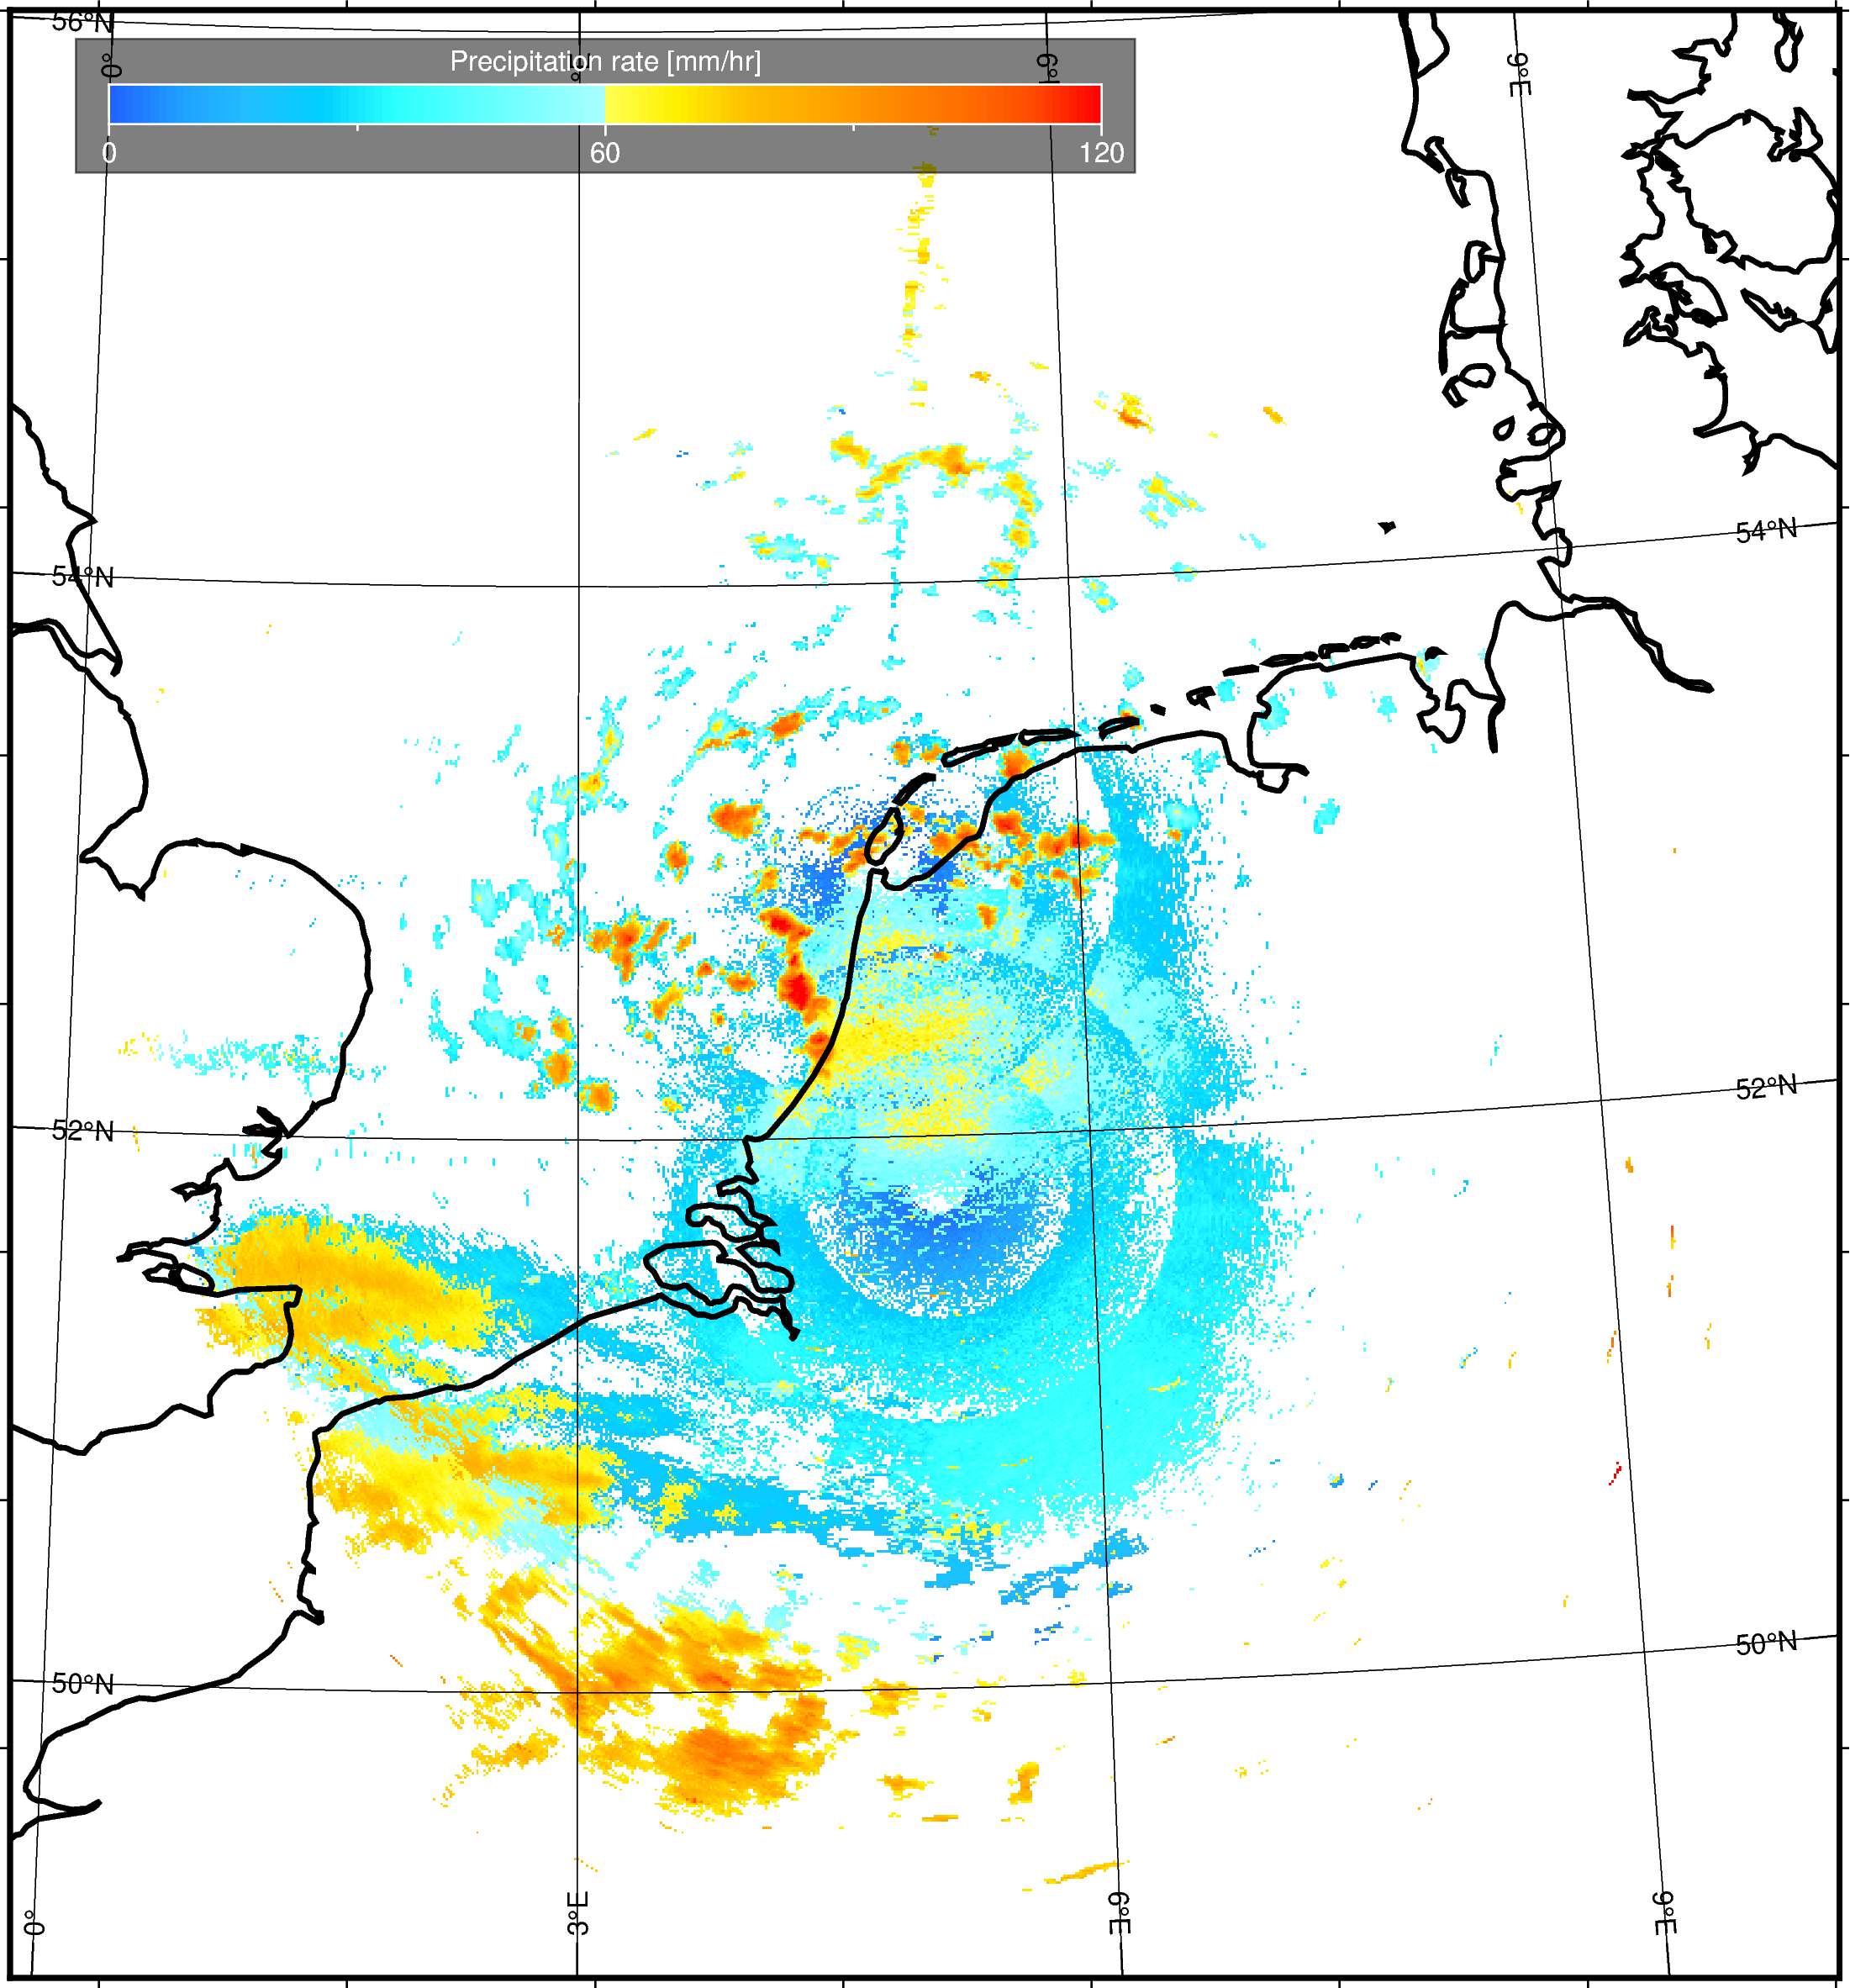

In [10]:
barwidth = 10

# Position string for feeding to the colorbar call. A bit coded, but the pyGMT 
# documents are great: https://www.pygmt.org/dev/api/index.html
pos_str = 'jTL+w' + str(barwidth) + 'c+jTL+o1c/0.75c+h+ml'

# Plot the color bar once with a transparent box, then again with no box and no transparency
with pygmt.config(FONT_ANNOT_PRIMARY = '8p,white', FONT_LABEL = '8p,white', 
                  MAP_ANNOT_OFFSET_PRIMARY = '2p', MAP_TICK_PEN_PRIMARY = '0.5p,white', 
                  MAP_TICK_LENGTH_PRIMARY = '3p', MAP_FRAME_PEN = '0.5p,white', MAP_LABEL_OFFSET = '4p'):
    fig.colorbar(cmap = 'precip.cpt', position = pos_str,
                 frame = 'xa60f30+l"Precipitation rate [mm/hr]"', box = '+gblack+p0.5p,black+c3p', t = '50')
    fig.colorbar(cmap = 'precip.cpt', position = pos_str, frame = 'xa60f30+l"Precipitation rate [mm/hr]"')

fig.show()